In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults, load_all_results
from utils.referral_handler import ReferralHandler, ReferralResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices
from plotting.main_seg_results import plot_seg_erros_uncertainties
from plotting.result_plots import plot_referral_results

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Experiments

All models were trained on fold 2 of the AD-DC data

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 3

# baseline: 
exp_base = {3: "20180509_18_36_23_dcnn_f3_150KE_lr2e02",
            2: "20180509_18_36_28_dcnn_f2_150KE_lr2e02",
            1: "20180509_18_36_32_dcnn_f1_150KE_lr2e02",
            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
exp_base_path = os.path.join(LOG_DIR, exp_base[TEST_FOLD])


exp_mc005_brier = {3: "20180428_09_11_35_dcnn_mc_f3p005_brier_150KE_lr2e02",
                   2: "20180426_14_47_23_dcnn_mc_f2p005_brier_150KE_lr2e02",
                   1: "20180426_14_45_50_dcnn_mc_f1p005_brier_150KE_lr2e02",
                   0: "20180418_15_02_36_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_brier_path = os.path.join(LOG_DIR, exp_mc005_brier[TEST_FOLD])


# 20180508_11_47_05_dcnn_mc_f2p01_brier_20KE_lr2e02
# 20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02
exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])



## Load experimental data and test data set

In [3]:
print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_base = ExperimentHandler.load_experiment(exp_base_path)
exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)
exper_hdl_base.set_model_name("Base DCNN fold-{} (p={})".format(
                                     exper_hdl_base.exper.run_args.fold_ids[0],
                                     exper_hdl_base.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_base.exper.model_name))


exper_mc005_brier = ExperimentHandler.load_experiment(exp_mc005_brier_path)
exper_hdl_mc005_brier = ExperimentHandler(exper_mc005_brier, use_logfile=False)
exper_hdl_mc005_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc005_brier.set_model_name("MC-dropout-brier fold-{} (p={})".format(
                                     exper_hdl_mc005_brier.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_brier.exper.model_name))


exper_mc01_brier = ExperimentHandler.load_experiment(exp_mc01_brier_path)
exper_hdl_mc01_brier = ExperimentHandler(exper_mc01_brier, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01_brier.exper.model_name))


try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc005_brier.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True)

  4%|▍         | 1/25 [00:00<00:02,  8.98it/s]

!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 3
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180509_18_36_23_dcnn_f3_150KE_lr2e02/stats/exper_stats.dll
Model name Base DCNN fold-3 (p=0.5)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180428_09_11_35_dcnn_mc_f3p005_brier_150KE_lr2e02/stats/exper_stats.dll
Model name MC-dropout-brier fold-3 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
Model name MC-dropout brier fold-3 (p=0.1)
INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:01<00:00, 12.67it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


## Evaluate models with referral

In [ ]:

for fold_id in [0]:
    exper_path = os.path.join(LOG_DIR, exp_mc01_brier[fold_id])
    experiment_mc = ExperimentHandler.load_experiment(exper_path)
    exper_handler = ExperimentHandler(experiment_mc, use_logfile=False)
    exper_handler.set_root_dir(ROOT_DIR)
    exper_handler.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                    exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                    exper_hdl_mc01_brier.exper.run_args.drop_prob))
    ref_test_set = ACDC2017TestHandler(exper_config=exper_handler.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[fold_id],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True)
    ref_thres = [0.18]
    # refer only positive, uncertain pixels
    ref_handler = ReferralHandler(exper_handler, test_set=ref_test_set, referral_thresholds=ref_thres,
                                  verbose=False, do_save=False, num_of_images=1, pos_only=True,
                                  aggregate_func="max")
    ref_handler.test(without_referral=True, verbose=False) 
    # Refer all uncertain pixels
    ref_handler = ReferralHandler(exper_handler, test_set=ref_test_set, referral_thresholds=ref_thres,
                                  verbose=False, do_save=False, num_of_images=1, pos_only=False,
                                  aggregate_func="max")
    ref_handler.test(without_referral=True, verbose=False) 
    # Overall result wo referral -  dice(RV/Myo/LV):	ES 0.87/0.88/0.96	ED 0.94/0.87/0.96
    # Overall result referral -  dice(RV/Myo/LV):	ES 0.90/0.90/0.96	ED 0.95/0.88/0.97


### Load referral results per threshold

In [10]:
exper_dict = exp_mc01_brier
referral_thresholds = [0.1, 0.12, 0.14, 0.16]  # [0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24] 

# ref_results_pos_only = ReferralResults(exper_dict, referral_thresholds, pos_only=True, print_results=False,
#                                       fold=None)
ref_results = ReferralResults(exper_dict, referral_thresholds, pos_only=False, print_results=False,
                              fold=None)

INFO - Loading referral results for thresholds [0.1, 0.12, 0.14, 0.16]
WARNING - referral positives-only=False
INFO - Saved results to /home/jorg/repository/dcnn_acdc/data/Folds/patient_cardiac_disease_classes.dll


In [ ]:
from in_out.generate_slice_features import SliceFeatureGenerator


referral_threshold = 0.14

slice_features = SliceFeatureGenerator(exper_dict, verbose=False, referral_threshold=referral_threshold)
slice_features.generate_features(num_of_bins=25, threshold=None, normalize=False)

In [173]:
from in_out.dataset_slice_referral import SliceReferralDataSet

cardiac_phase = 0
slice_dataset = SliceReferralDataSet(ref_results, slice_features, referral_threshold=referral_threshold,
                                     verbose=True)
x_train, y_train, x_test, y_test, train_ids, test_ids =  \
    slice_dataset.split_train_test_set(fold_id=3, cardiac_phase=cardiac_phase)
print(np.unique(train_ids))

('x_train, x_test ', (703, 30), (248, 30))
('y_train, y_test ', (703,), (248,))
[   6.    7.    8.    9.   10.   11.   12.   13.   14.   15.   16.   17.
   18.   19.   20.   26.   27.   28.   29.   30.   31.   32.   33.   34.
   35.   36.   37.   38.   39.   40.   46.   47.   48.   49.   50.   51.
   52.   53.   54.   55.   56.   57.   58.   59.   60.   66.   67.   68.
   69.   70.   71.   72.   73.   74.   75.   76.   77.   78.   79.   80.
   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.
   98.   99.  100.]


In [170]:
from sklearn.ensemble import RandomForestRegressor as rfreg
from sklearn.metrics import r2_score

cardiac_phase = 1
slice_dataset = SliceReferralDataSet(ref_results, slice_features, referral_threshold=referral_threshold,
                                     verbose=True)
slice_dataset.verbose = False
importances = 0
rf = rfreg(n_estimators=100)
for fold_id in np.arange(4):
    x_train, y_train, x_test, y_test, train_ids, test_ids = \
            slice_dataset.split_train_test_set(fold_id=fold_id, cardiac_phase=cardiac_phase)
    rf.fit(x_train, y_train)
    y_test_pred = rf.predict(x_test)
    importances += rf.feature_importances_
    
print(importances * 1./4)
r2_metric = r2_score(y_test, y_test_pred)
print(r2_metric)

[ 0.14063343  0.10192835  0.03587326  0.01864645  0.01872336  0.01302427
  0.0206634   0.02899692  0.02279025  0.02576987  0.041917    0.03551796
  0.03607423  0.05209185  0.04401945  0.02396798  0.0172331   0.01143621
  0.01986175  0.01520175  0.00742478  0.00259276  0.00100315  0.00077645
  0.00036592  0.17464724  0.01229175  0.0161541   0.06037302]
0.369649096476


In [78]:
path_to_root_fold = os.path.join(ROOT_DIR, config.data_dir)
ublob_stats = UncertaintyBlobStats.load(path_to_root_fold)
ublob_stats.set_min_area_size(filter_type="M")

referral_threshold = 0.1

slice_seg_error = ref_results.img_slice_seg_error_improvements[referral_threshold]
slice_blobs = ref_results.slice_blobs[referral_threshold]
total_blobs_es = 0
total_blobs_ed = 0
blob_values_es = []
blob_values_ed = []

patients_per_category = {'NOR': 0, 'DCM': 0, 'MINF': 0, 'ARV': 0, 'HCM': 0}
total_blob_uncertainty_es = {'NOR': 0, 'DCM': 0, 'MINF': 0, 'ARV': 0, 'HCM': 0}
total_blob_uncertainty_ed = {'NOR': 0, 'DCM': 0, 'MINF': 0, 'ARV': 0, 'HCM': 0}
total_num_of_slices = {'NOR': 0, 'DCM': 0, 'MINF': 0, 'ARV': 0, 'HCM': 0}
num_of_slices_referred_es = {'NOR': 0, 'DCM': 0, 'MINF': 0, 'ARV': 0, 'HCM': 0}
num_of_slices_referred_ed = {'NOR': 0, 'DCM': 0, 'MINF': 0, 'ARV': 0, 'HCM': 0}
patient_slices_referred = {}

for patient_id, seg_diffs in slice_seg_error.iteritems():
    # print("Patient {}".format(patient_id))
    p_category = ref_results.patients[patient_id]
    patients_per_category[p_category] += 1
    seg_diffs_es = seg_diffs[0]
    seg_diffs_ed = seg_diffs[1]
    slice_blobs_es = slice_blobs[patient_id][0]
    slice_blobs_ed = slice_blobs[patient_id][1]
    total_blobs_es += np.count_nonzero(slice_blobs_es)
    total_blobs_ed += np.count_nonzero(slice_blobs_ed)
    total_num_of_slices[p_category] += seg_diffs_es.shape[0]

    blob_values_es.append((slice_blobs_es * (slice_blobs_es > 10)).sum(axis=1))
    blob_values_ed.append((slice_blobs_ed * (slice_blobs_ed > 10)).sum(axis=1))
    l_array_es = blob_values_es[-1]
    l_array_ed = blob_values_ed[-1]
    total_blob_uncertainty_es[p_category] += np.sum(l_array_es)
    total_blob_uncertainty_ed[p_category] += np.sum(l_array_ed)
    es_filter_value = ublob_stats.min_area_size[referral_threshold][0]
    ed_filter_value = ublob_stats.min_area_size[referral_threshold][1]
    idx_es = np.argwhere(l_array_es >= es_filter_value)[:, 0]
    idx_ed = np.argwhere(l_array_ed >= ed_filter_value)[:, 0]
    patient_slices_referred[patient_id] = [idx_es, idx_ed]
    num_of_slices_referred_es[p_category] += idx_es.shape[0]
    num_of_slices_referred_ed[p_category] += idx_ed.shape[0]
    if patient_id in ["patient081",  "patient082", "patient083", "patient084"]:
        print("Patient {} ({}) ES/ED u-values {}/{}".format(patient_id, p_category,
                                                            np.sum(l_array_es), np.sum(l_array_ed)))     
        print(l_array_es)      
        print(idx_es + 1)
        print(idx_ed + 1)

blob_values_es = np.concatenate(blob_values_es, axis=0)
blob_values_ed = np.concatenate(blob_values_ed, axis=0)
print(len(blob_values_es), np.mean(np.array(blob_values_es)), np.median(np.array(blob_values_es)),
      np.std(np.array(blob_values_es)))
print(len(blob_values_ed), np.mean(np.array(blob_values_ed)), np.median(np.array(blob_values_ed)),
      np.std(np.array(blob_values_ed)))

print("Statistics per p-class for referral_threshold {:.2f}".format(referral_threshold))

for p_cat, total_uncertainty_es in total_blob_uncertainty_es.iteritems():
    total_uncertainty_ed = total_blob_uncertainty_ed[p_cat]
    total_slices_cat = total_num_of_slices[p_cat]
    print("Category {}".format(p_cat))
    perc_ref_es = 100 * num_of_slices_referred_es[p_cat] * 1./total_slices_cat
    perc_ref_ed = 100 * num_of_slices_referred_ed[p_cat] * 1./total_slices_cat
    print("Mean u-value {:.2f}/{:.2f}\t" 
          "% slices referred {:.2f}/{:.2f}".format(total_uncertainty_es * 1./total_slices_cat,
                                                   total_uncertainty_ed * 1./total_slices_cat,
                                                   perc_ref_es, perc_ref_ed))

    




Patient patient005 (DCM) ES/ED u-values 9728/5418
[2084 1303 1261 1047  986  648  685  543  607  564]
[1 2 3 4 5 7]
[ 1 10]
Patient patient045 (MINF) ES/ED u-values 8935/6352
[1568 1637 2037 1056  420  557  927  733]
[1 2 3 4 7 8]
[1 2 3 7 8]
Patient patient081 (ARV) ES/ED u-values 10814/9934
[   0 1236 2010 1572  330  211  687  660  421  624  573  397  369  450  426
  353  495]
[2 3 4 7]
[ 1  2 10 17]
951 681.990536278 500.0 582.669996509
951 549.679284963 335.0 639.922097965
Statistics per p-class for referral_threshold 0.10
Category ARV
Mean u-value 844.79/671.79	% slices referred 47.77/43.30
Category DCM
Mean u-value 782.90/633.78	% slices referred 36.92/33.85
Category MINF
Mean u-value 667.69/543.24	% slices referred 34.10/35.26
Category NOR
Mean u-value 467.85/341.12	% slices referred 21.18/12.94
Category HCM
Mean u-value 590.63/511.68	% slices referred 29.10/27.51


In [74]:
from utils.uncertainty_blobs import UncertaintyBlobStats

referral_thresholds = [0.1, 0.12, 0.14, 0.16]
ublob = UncertaintyBlobStats(exper_dict, referral_thresholds)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Saved results to /home/jorg/repository/dcnn_acdc/data/Folds/UncertaintyBlobStats.dll


Rows/columns 3/3


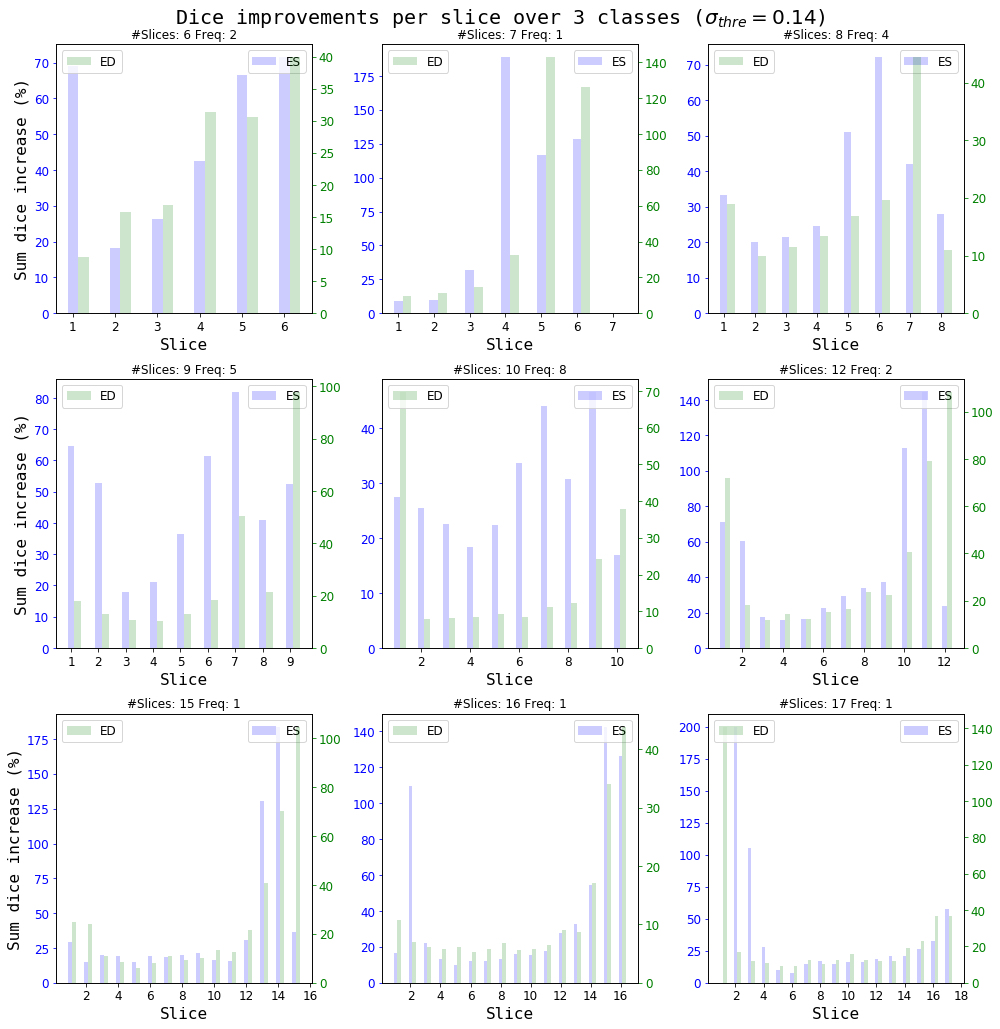

In [5]:
from plotting.referral_stats_plots import histogram_slice_acc, diff_slice_acc

ref_threshold = 0.14
plot_title = r"Dice improvements per slice over 3 classes ($\sigma_{{thre}}={:.2f}$)".format(ref_threshold)

histogram_slice_acc(ref_results, do_show=True, do_save=False,
                    width=14, referral_threshold=ref_threshold, plot_title=plot_title)

### Print referral results per referral threshold

[ 0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85]
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/figures/DCNN-MC (p=0.1)_referral_results.pdf


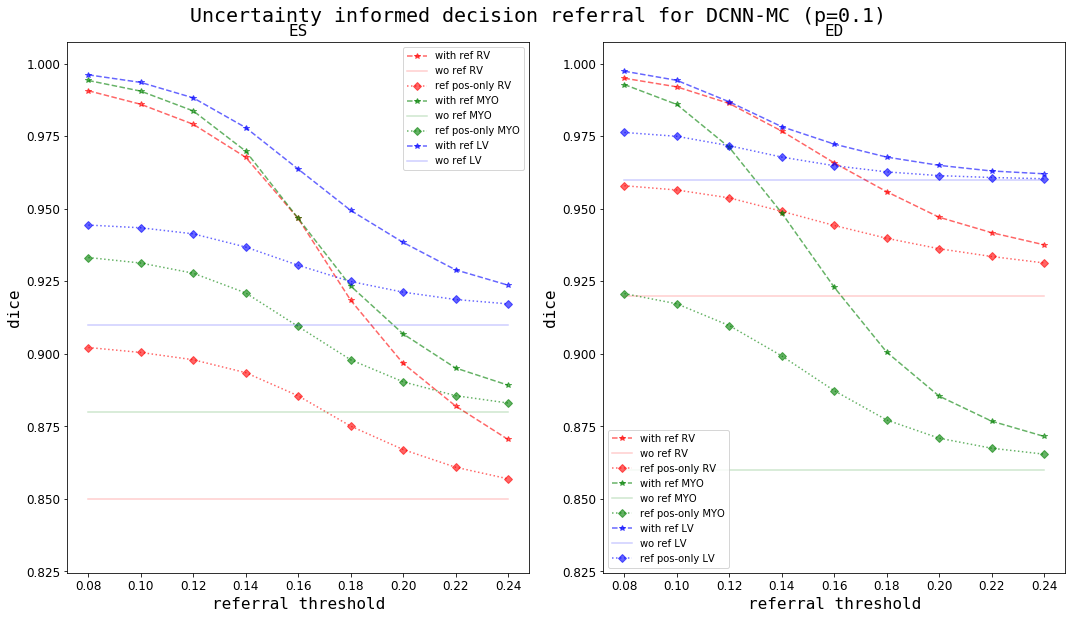

In [26]:

model_name = "DCNN-MC (p=0.1)"
plot_referral_results(ref_results.dice, model_name,
                      ref_results_pos_only.dice, width=16 , height=9, do_save=True)

## Run model evaluation of test set

In [4]:
mc_samples = 10
sample_weights = True
store_details = False
image_range =  [0] # None # [0, 9, 22] #  [24]

generate_stats = False

save_results = True
checkpoints = None  #  [150000]  [130000, 140000, 150000]
use_uncertainty = False
referral_threshold = 0.
ref_positives_only = False
# if not sample_weights & save_pred_labels => we save pred_labels & referred_pred_labels
save_pred_labels = False

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_pred_labels=save_pred_labels)

   
print("Ready")

INFO - Evaluating model MC-dropout brier fold-3 (p=0.1) on checkpoints 100000, 110000, 120000, 130000, 140000, 150000
INFO - Running test on 1 images
Loading existing model witth checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 100000
Loading existing model witth checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 110000
Loading existing model witth checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 120000
Loading existing model witth checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 130000
Loading existing model witth checkpoint /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints from dir 140000
Loading existing model witth checkpoint /home/jorg/repository/dcnn_acd

In [39]:
from utils.test_results import load_all_results
# Dictionaries with experiment folder per fold-id
# exp_mc005_brier
# exp_mc01_brier
# exp_base
res_dice, res_hd = load_all_results(exp_mc01_brier, search_prefix="test_results_25imgs_mc*")


/home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/test_results_25imgs_mc*.dll
Compute mean results for experiment!
[ 0.99807897  0.86854095  0.89081094  0.9199606   0.99849339  0.93697451
  0.88008932  0.96323709]
/home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/test_results_25imgs_mc*.dll
[ 0.99796511  0.83710505  0.87319641  0.89854759  0.99820332  0.92711516
  0.85100477  0.9564519 ]
/home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/test_results_25imgs_mc*.dll
[ 0.99787722  0.84071494  0.8759106   0.90849661  0.99797723  0.90855784
  0.85496894  0.95196594]
/home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/test_results_25imgs_mc*.dll
[ 0.99804603  0.83411385  0.88077671  0.91679499  0.99824464  0.92042961
  0.86378225  0.95846849]
Overall:	dice(RV/Myo/LV): ES 0.85 (0.08)/0.88 (0.04)/0.91 (0.06)	ED 0.92 (0.04)/0.86 (0

In [ ]:
exper_handler.create_filtered_umaps(u_threshold=0.14)

## Run evaluation of MC model with referral

In [11]:
mc_samples = 10
sample_weights = True
store_details = True
image_range = [1] # [9] # [10, 24] #  [24]
if sample_weights:
    generate_stats = True
else:
    generate_stats = False
save_results = False
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = False
referral_threshold = 0.
ref_positives_only = True
save_pred_labels = False

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=True, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_pred_labels=save_pred_labels)



print("Ready")

Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/checkpoints
Evaluating model MC-dropout brier fold-3 (p=0.1) - runID 1
INFO - Running test on 1 images with model from checkpoint 150000
	 Segmentation errors - 	ES 0.0/246.0/95.0		ED 103.0/195.0/99.0
	 Segmentation errors - 	ES 130.0/214.0/104.0		ED 90.0/253.0/112.0
	 Segmentation errors - 	ES 103.0/270.0/110.0		ED 123.0/254.0/93.0
	 Segmentation errors - 	ES 105.0/334.0/159.0		ED 82.0/252.0/135.0
	 Segmentation errors - 	ES 80.0/286.0/133.0		ED 40.0/267.0/162.0
	 Segmentation errors - 	ES 44.0/293.0/128.0		ED 58.0/243.0/139.0
	 Segmentation errors - 	ES 36.0/222.0/89.0		ED 18.0/208.0/112.0
	 Segmentation errors - 	ES 21.0/190.0/83.0		ED 17.0/189.0/115.0
	 Segmentation errors - 	ES 10.0/233.0/83.0		ED 0.0/200.0/100.0
	 Segmentation errors - 	ES 0.0/148.0/28.0		ED 0.0/272.0/42.0
Image 2-patient002 - test loss -2.138  dice(RV/Myo/LV):	ES 0.82/0.88/0.9

## Run evaluation for baseline DCNN model

In [ ]:
mc_samples = 1
sample_weights = False
store_details = False
image_range =  None # [0, 9, 22] #  [24]

generate_stats = False

save_results = True
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = False
referral_threshold = 0.
ref_positives_only = False
# if not sample_weights & save_pred_labels => we save pred_labels & referred_pred_labels
save_pred_labels = True

exper_handler = exper_hdl_base

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_pred_labels=save_pred_labels)


    
print("Ready")

In [220]:
exper_handler.create_filtered_umaps(u_threshold=0.14, verbose=True, patient_id="patient005")
print("Ready")

Slice 9 count 55769 sum-unc 619.34
After f-con-comps (c=0) 517/517
After f-con-comps (c=1) 97/97
After f-con-comps (c=2) 474/474
After f-con-comps (c=3) 178/0
After f-con-comps (c=0) 470/0
After f-con-comps (c=1) 259/0
After f-con-comps (c=2) 345/0
After f-con-comps (c=3) 174/0
INFO - Creating 25 filtered u-map-0.14 in /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/u_maps
Ready


In [ ]:
exper_handler = exper_hdl_mc005_brier

# image_ids = exper_handler.test_results.image_ids

image_range = None
u_type = "stddev"

analyze_slices(exper_handler, image_range=image_range, do_save=True, do_show=True, u_type=u_type,
               use_saved_umaps=True)

# Compare performance of models

In [ ]:
image_range = [24]

for img_idx in image_range:
    exper_handler.test_results.visualize_uncertainty_stats(image_num=img_idx, width=16, height=10, 
                                                     info_type="probs",
                                                     do_save=True, do_show=False,
                                                     model_name=exper_handler.exper.model_name)

In [ ]:
exper_handler.test_results.generate_all_statistics()
u_values_slices = exper_handler.test_results.image_probs_categorized[0]
for slice_id in range(len(u_values_slices)):
    u_values_slice = u_values_slices[slice_id]
    print(len(u_values_slice["es_err_std"][1]), len(u_values_slice["es_cor_std"][1]))

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
Rows/columns/height 22/4/86
330, 17, 15, 6
[130]
405, 15, 8, 4, 3, 2
[135]


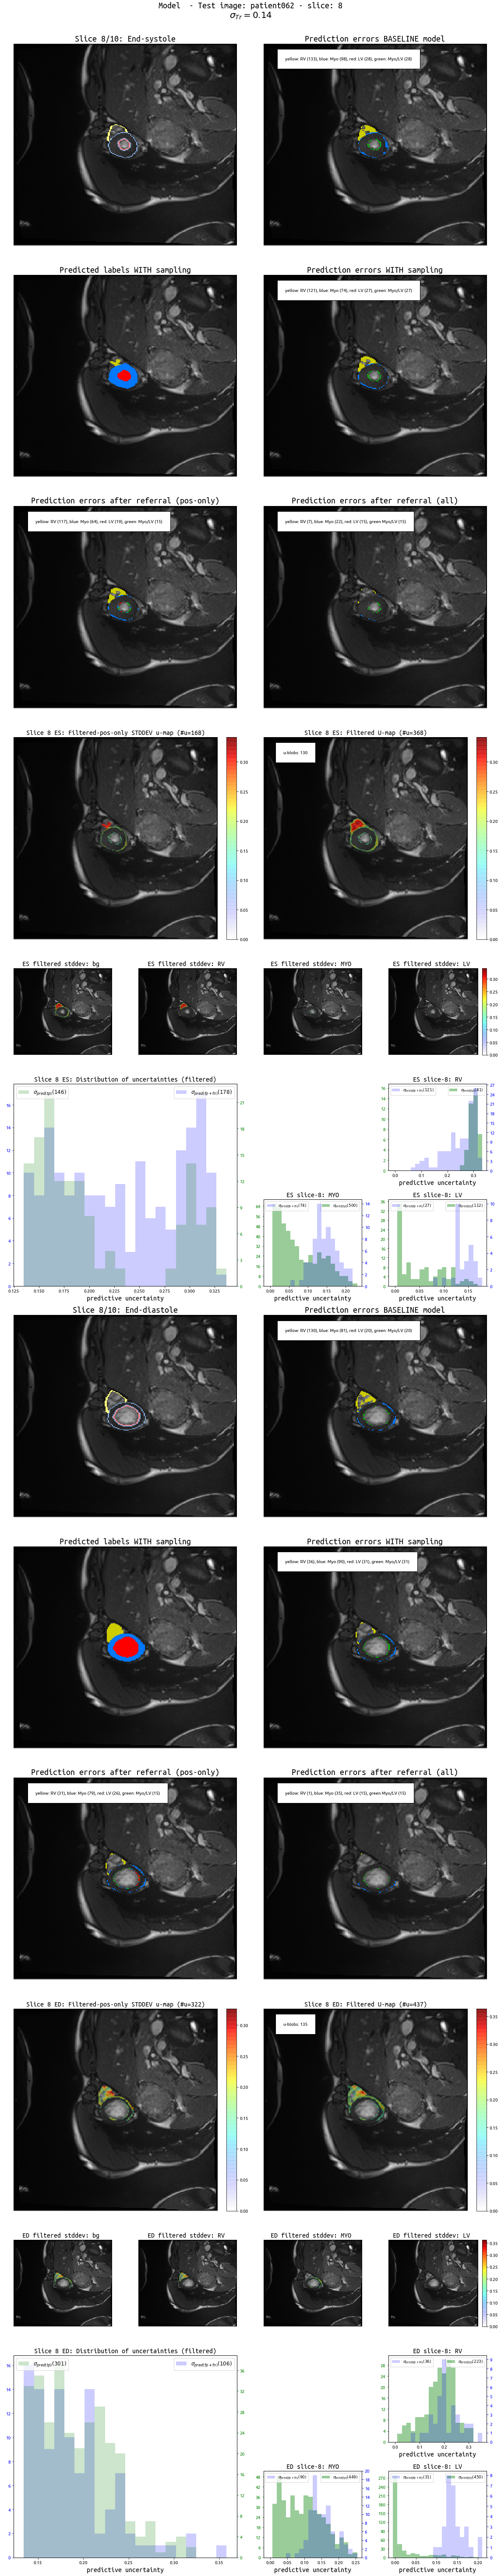

In [14]:
exp_path = os.path.join(LOG_DIR, exp_mc01_brier[3])
exper = ExperimentHandler.load_experiment(exp_path)
exper_handler = ExperimentHandler(exper, use_logfile=False)
exper_handler.set_root_dir(ROOT_DIR)
# exper_handler = exper_hdl_mc01_brier
model_name = exper_handler.exper.model_name

plot_seg_erros_uncertainties(exper_handler, test_set, patient_id="patient062", 
                             test_results=None, # exper_handler.test_results
                             referral_threshold=0.14, do_show=True, 
                             model_name=model_name, info_type="uncertainty", 
                             do_save=False, slice_range=[7], errors_only=False,
                             load_base_model_pred_labels=True)

In [ ]:
# model_name a) Baseline  b) MC-dropout 0.1

model_name = exper_handler.exper.model_name
errors_only = False  # in case of the BASELINE model we only want the seg-errors
plot_detailed_hists = True
image_range = [0]
if image_range is None:
    image_range = np.arange(len(exper_handler.test_results.image_names))


for image_num in image_range:
    exper_handler.test_results.visualize_uncertainty_histograms(image_num=image_num, width=20, height=60, 
                                                                 info_type="uncertainty",
                                                                 do_save=False, slice_range=[0, 1],
                                                                 std_threshold=0.12, errors_only=errors_only, 
                                                                 do_show=True, use_bald=True,
                                                                 model_name = model_name,
                                                                 plot_detailed_hists=plot_detailed_hists,
                                                                 load_referral=True, ref_positives_only=True)
                                                                 # uncertainty
    print("INFO - Ready!")


(227, 250)


(-0.5, 249.5, 226.5, -0.5)

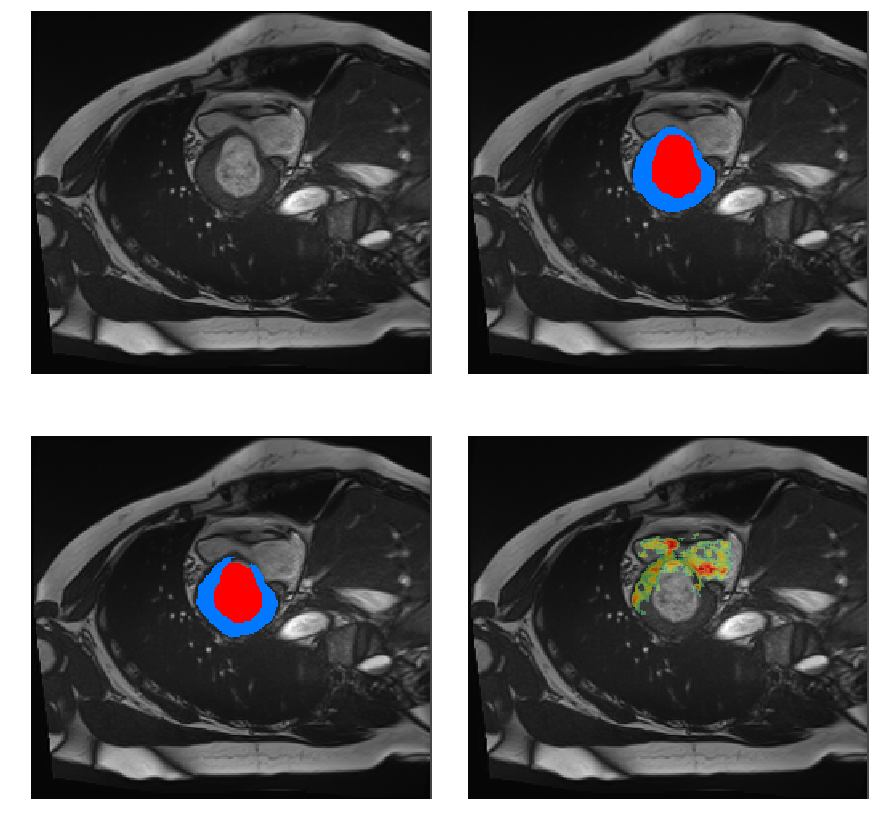

In [25]:
import copy
from common.common import overlay_seg_mask, to_rgb1a

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap


#Use base cmap to create transparent
mycmap = transparent_cmap(plt.get_cmap('jet'))

exper_handler = exper_hdl_mc01_brier
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.u_map_dir))
pred_lbl_input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.pred_lbl_dir))

file_name_umap = os.path.join(input_dir, "patient002_filtered_umaps_max0_16.npz")

file_name_lbl = os.path.join(pred_lbl_input_dir, "patient002_pred_labels_mc.npz")

file_name_ref_lbl = os.path.join(pred_lbl_input_dir, "patient002_filtered_pred_labels_mc0_16_pos_only.npz")

umap_data = np.load(file_name_umap)
umap = umap_data["filtered_umap"]
data_lbl = np.load(file_name_lbl)
pred_labels = data_lbl["pred_labels"]
data_ref_lbl = np.load(file_name_ref_lbl)


org_img = exper_handler.test_results.images[0]
org_ref = exper_handler.test_results.labels[0]
org_img_ed = org_img[0]
org_img_ed_slice3 = org_img_ed[:, :, 0]
umap_slice = umap[0, :, :, 0]
print(umap_slice.shape)

rgb_org_img_ed_slice3 = to_rgb1a(org_img_ed_slice3)
saved_rgb_copy = copy.deepcopy(rgb_org_img_ed_slice3)
org_ref_ed_slice3 = org_ref[:, :, :, 0]
pred_ref_ed_slice3 = pred_labels[:, :, :, 0]

img_slice_with_gt_segs = overlay_seg_mask(rgb_org_img_ed_slice3, org_ref_ed_slice3, cls_offset=0)
rgb_org_img_ed_slice3 = copy.deepcopy(saved_rgb_copy)
mg_slice_with_pred_segs = overlay_seg_mask(rgb_org_img_ed_slice3, pred_ref_ed_slice3, cls_offset=0)

fig = plt.figure(figsize=(15, 15))
ax4plot = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax4plot.imshow(org_img_ed_slice3, cmap=plt.get_cmap('gray'))
plt.axis("off")
ax4aplot = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax4aplot = plt.imshow(img_slice_with_gt_segs)
plt.axis("off")
ax4bplot = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax4bplot = plt.imshow(mg_slice_with_pred_segs)
plt.axis("off")
ax4bplot = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2)
ax4bplot = plt.imshow(org_img_ed_slice3, cmap=cm.gray)
ax4bplot = plt.imshow(umap_slice, cmap=mycmap)

plt.axis("off")

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax4plot = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax4plot = plt.imshow(u_map_slice, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax4plot = plt.imshow(u_map_slice_pos_only, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax4plot = plt.imshow(pred_labels_slice_es, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2)
ax4plot = plt.imshow(ref_pred_labels_slice_es, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")

plt.show()

del u_map
del u_map_es
del u_map_slice

(2, 4, 257, 217, 10)
0.38065009924


(-0.5, 216.5, 256.5, -0.5)

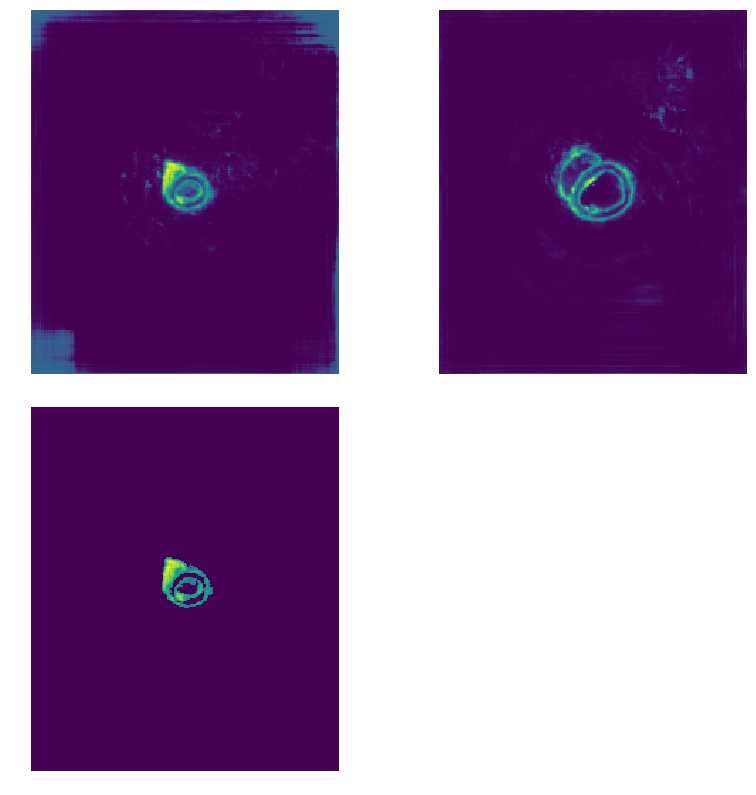

In [273]:
from utils.post_processing import filter_connected_components
import copy

input_dir = "/home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/u_maps/"
file_name = os.path.join(input_dir, "patient005_raw_umaps.npz")
data = np.load(file_name)
# u_map = data["filtered_umap"]
u_map = data["u_map"]
print(u_map.shape)
# u_map_slice = u_map[1, :, :, 9]
u_map_slice1 = np.max(u_map[1, :, :, :,9], axis=0)
u_map_slice2 = np.max(u_map[1, :, :, :,8], axis=0)
print(np.max(u_map_slice1.flatten()))

u_map_filtered_slice1 = copy.deepcopy(u_map_slice1)
u_map_filtered_slice1[u_map_slice1 < 0.14] = 0
u_map_filtered_slice1 = filter_connected_components(u_map_filtered_slice1, threshold=0.14)

fig = plt.figure(figsize=(14, 14))
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax1.imshow(u_map_slice1)
plt.axis('off')
ax1 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax1.imshow(u_map_slice2)
plt.axis('off')
ax1 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax1.imshow(u_map_filtered_slice1)
plt.axis('off')